In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Data Loading

In [ ]:
train = pd.read_csv("../input/Kannada-MNIST/train.csv")
test = pd.read_csv("../input/Kannada-MNIST/test.csv")

Preparing dataset

In [ ]:
Y = train["label"]

# Drop 'label' column
X = train.drop(labels = ["label"],axis = 1) 

In [ ]:
# Normalize the data
X = X / 255.0
test = test / 255.0

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X = X.values.reshape(-1,28,28,1)

In [ ]:
X.shape

In [ ]:
#Dropping id column
x_test=test.drop('id', axis=1).iloc[:,:].values
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_test.shape

Let's plot and see the dataset

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure(num='digit',figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.title(Y[i])
    plt.imshow(np.squeeze(X[i,:,:,]))
plt.show()

In [ ]:
# Converting dependent variables into categorical data
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y, num_classes = 10)

In [ ]:
# Splitting dataset into taining and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=42)

# CRNN : CNN + RNN
CRNN is a network that combines CNN and RNN to process images containing sequence information such as letters.

It is mainly used for OCR technology and has the following advantages.

    End-to-end learning is possible.
    Sequence data of arbitrary length can be processed because of LSTM which is free in size of input and output sequence.
    There is no need for a detector or cropping technique to find each character one by one.

You can use CRNN for OCR, license plate recognition, text recognition, and so on. It depends on what data you are training.

## Model
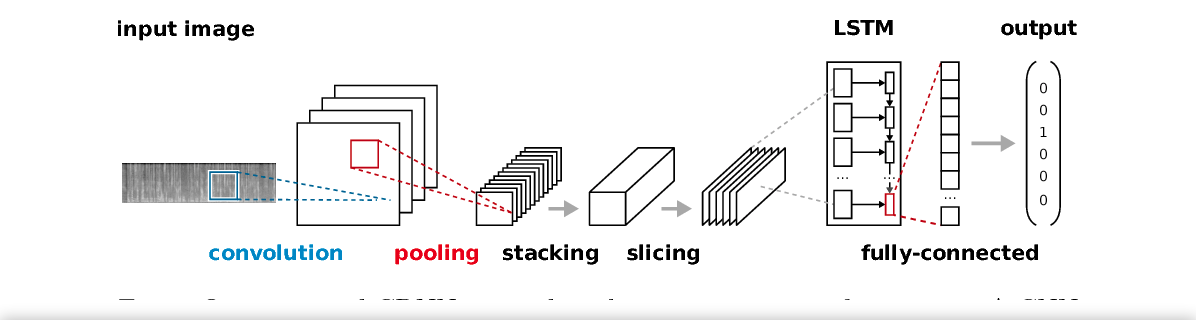

## Layers

There are mainly three layers in CRNN architecture

### Convolutional Layer

Extracts features through CNN Layer (VGGNet, ResNet ...).

### Recurrent Layer

Splits the features into a certain size and inserts them into the input of the Bidirectional LSTM or GRU.

### Transcription Layer

Conversion of Feature-specific predictions to Label using CTC (Connectionist Temporal Classification).


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU
from keras.layers import LeakyReLU
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
hidden_unit = 32
kernel_size = 3

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu',input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same' , activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same' , activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same' , activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same' , activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same' , activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(1,2), strides=(1,2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(GRU(hidden_unit,return_sequences=True)))
model.add(Flatten())
model.add(Dense(256 , activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))

Use Keras Data Generator to create more data

In [ ]:
datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False)  
datagen.fit(X_train)

In [ ]:
optimizer = RMSprop(lr=0.005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 50
batch_size = 128

In [ ]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate])

Let's plot the loss and accuracy curves for training and validation to see how our model performed

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


Let's plot confusion matrix and see how our model is performing on validation dataset

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.figure(num='digit',figsize=(9,9))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
#Display some error results 
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    plt.figure(num='digit',figsize=(9,9))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# predict results
results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="label") 

In [ ]:
submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')
submission['label'] = results

Submit the results

In [ ]:
submission.to_csv("submission.csv",index=False)

### Things to do next 
The fllowing tweak can be implemented on architecure to get better result.
- Add more LSTM network
- Impelement and use CTC loss 
- Different activation function

**I hope you liked the notebook.
If you find this notebook useful please upvote!!!**